# Aquaseca basic domain
## Former Model Description before GroMore proposal 
This is a steady state box model with recharge and ET. An additional layer was also added to the model.

#### Dimensions: 
- 50 by 50 by 1
- dx = dy = 100 m
- dz = varied 
- three layers

#### Topography
- Top layer elevation given in csv file
- Middle layer is flat and 5m thick
- Bottom layer (Layer 3) is flat and 40m thick

#### Subsurface Properties: 
- Porosity = 0.1
- Specific yield = 0.1
- Storage coefficient=0.0001 
- Homogeneous in each layer
##### Layers
 - Layer 1 = Layer 3
     - Kx=Ky=Kz= 10m/d
 - Layer 2 
     - 20 leftmost columns, Kx=Ky=Kz= 10m/d
     - Other columns, Kz= 0.0001m/d

#### Boundary Conditions: 
 - Right boundary is a constant head of 70 m relative to datum for all layers (datum is at bottom of domain)
 - All other boundaries are no flow
 - Top left corner: no flow
     - Extends from row 45, column 1 to row 50, column 6, inclusive, comprising a total of 21 no flow cells
 - A symmetric no flow region exists in the bottom left corner
     - row 41, column 1 to row 50, column 10.
 - Middle layer has no flow regions
     - Extends from row 43, column 1 to row 50, column 8 
 


*For simplicity, we will consider a year to be comprised of 12 30-day months.

## 1. Import packages

In [1]:
#import packages
import flopy
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from pyDOE import * #lhs

#additional analysis tools
import flopy.utils.binaryfile as bf
from flopy.utils.sfroutputfile import SfrFile

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
np.set_printoptions(threshold=np.inf)


moddir="C:/WRDAPP/MF2005.1_12/bin/mf2005.exe"
#modws ="C:/Users/davem/Documents/Thesis/modflow/mfoutput"
modws = "D:/mfoutput"

#jupyter specific--included to show plots in notebook
%matplotlib inline 

Parameter Values

K1, K2, and K3 = [5, 25, 100] # baseline Kx=Ky=Kz value in all zones (m/day)

Kz ratio_lowK = [1e-6, 1e-2, 1] # ratio of Kz in low-K layer to baseline K (-)

Sy = [0.05, 0.1, 0.3] # specific yield (-)

R_mountains = [1e-5, 3e-5, 5e-5] # recharge rate in mountains (m/day)

ET_valley = [1e-6, 1e-5, 1e-4] # ET rate in valley (m/day)

ETratio_riparian = [1, 2, 3] # ratio of ET in riparian area to ET rate in valley (m/day)

Kstreambed = [1,20]

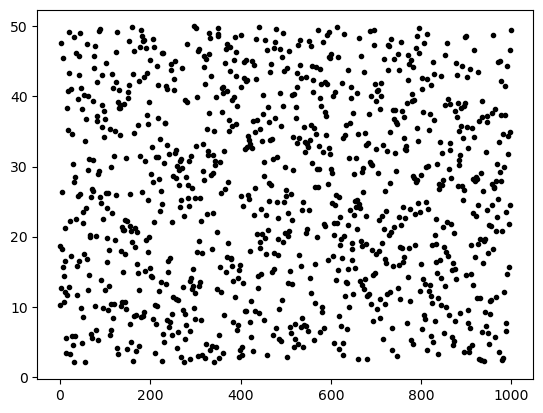

49.9771722334895
2.0458522035382605


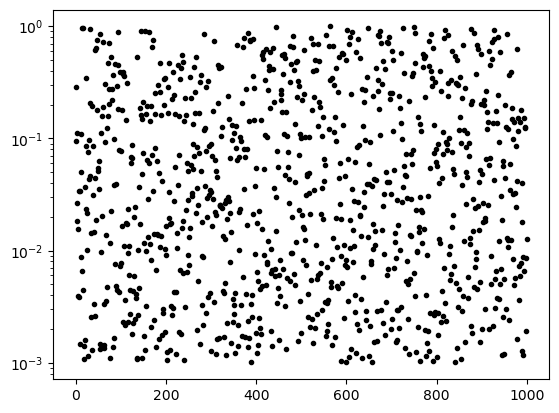

0.9965069915778751
0.0010055223242399036


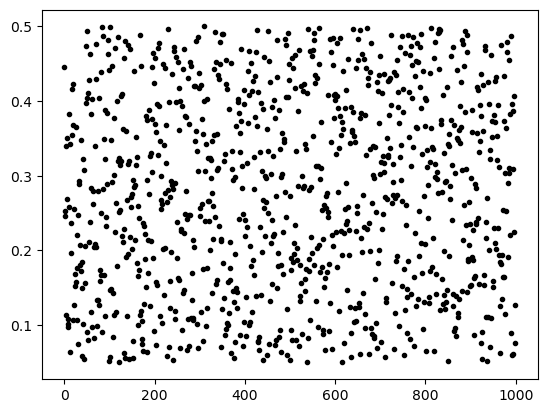

0.49970404186887807
0.050006846235041987


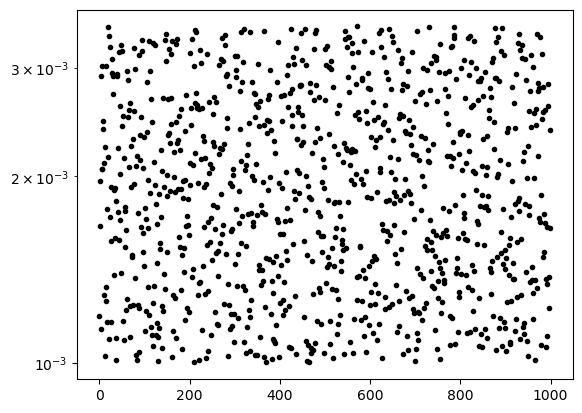

0.0034964266302531534
0.0010005345413735907


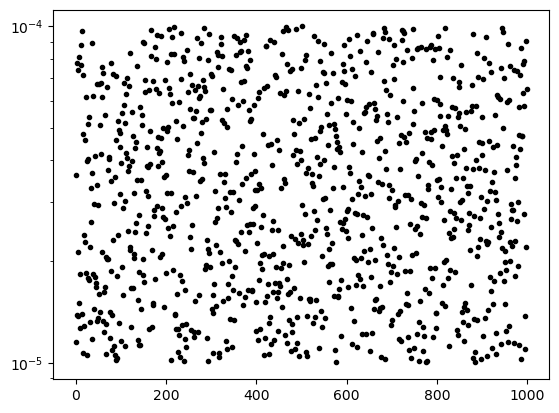

9.988667920995236e-05
1.000744929774467e-05


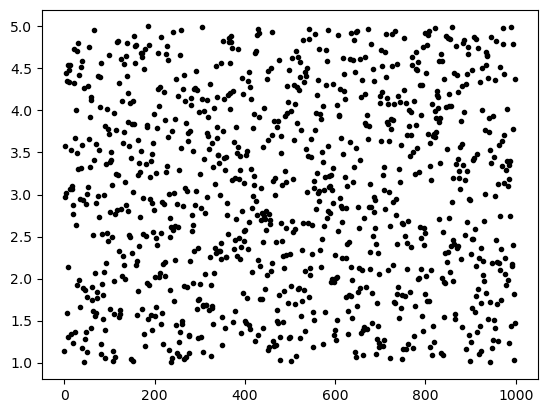

4.99954580895651
1.0012177689754547


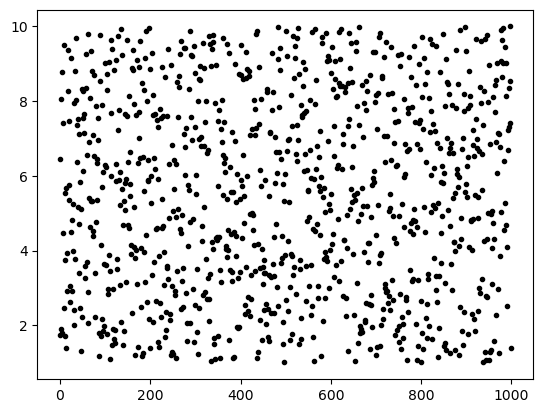

9.997111337249555
1.0050955676172324


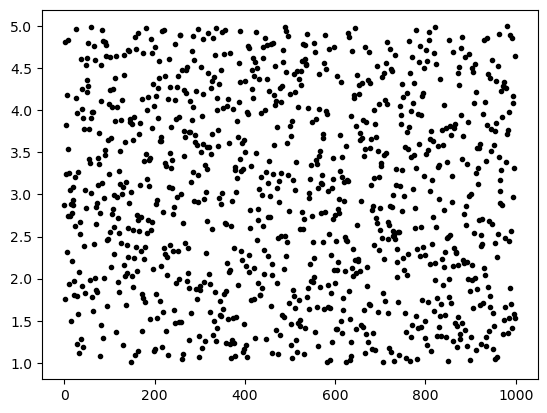

4.99635847364063
1.0038660269871873


In [2]:
#Set up parameter for ensemble
# K_h = [2, 50]       #was 5 to 100                                                                                                                      # base case retardation
# Kz_ratio = [0.001, 1]     
# Ka = [5, 100] #streambed K
# Sy = [0.05,0.3]                                                                                                                         
# R_mtn = [0.00003,0.00005]  #set 2e-5 as minimum for convergence
# ET_val = [0.0001,0.000001]   
# ET_ratio_rip = [1,3]
# krs = [0.0001, 0.005]


#Set up parameter for ensemble
K_h = [2,50]#[2, 10]  #hone in on this one perhaps use 0.05                                                                                                                        
Kz_ratio = [0.001, 1]                                                                                                                   
Sy = [0.05,0.5] #Sy = [0.05,0.5]                                                                                                                            
R_mtn = [0.001,0.0035]  #set 2e-5 as minimum for convergence
ET_val = [0.00001,0.0001] #[0.000001,0.00001]   
ET_ratio_rip = [1,5]
Krs = [1, 10]#krs = [0.001, 0.01] 
#Anis = [0.01, 1] # anistrophy! - not used below
pump_rate = [1,5]

num = 1000
npars = 8
#latin hyper cube sampling
sampling = lhs(npars, samples = num)
#print(sampling)
params = np.array([K_h, Kz_ratio, Sy, R_mtn, ET_val, ET_ratio_rip, Krs, pump_rate])
#params = np.array([K_h, Kz_ratio, Sy, ET_val, ET_ratio_rip, Krs, pump_rate])

logpars = [1,3,4]
for i in range(npars):
    if(i in logpars):
        #log
        sampling[:,i] = 10**(np.log10(params[i][0]) + (np.log10(params[i][1]) - np.log10(params[i][0]))*sampling[:,i])
    else:
        #Linear 
        sampling[:,i] = params[i][0] + (params[i][1] - params[i][0])*sampling[:,i]
    
for i in range(npars):
    plt.plot(sampling[:,i], 'k.')
    if i in logpars:
        plt.yscale('log')
    plt.show()
    print(np.max(sampling[:,i]))
    print(np.min(sampling[:,i]))
    
    
np.savetxt("ModflowParams8-1000Test12.txt", sampling)
#np.savetxt("ModflowParams8-1000Test5.txt", sampling)

## 2. Discretization and other inputs

In [3]:
# Discretization
nrow = 50 #number of rows
ncol = 50 #number of columns
nlay = 3  #number of layers

width = 100
dx= width #width of grid cells in x direction 
dy= width #width of grid cells in y direction 
Lx = ncol*dx  #width of domain in x
Ly = nrow*dy #width of domain in y

#ztop = 100
ztop = np.genfromtxt('../base/base_model_elevs.csv', delimiter=',', dtype=float)   # top elevation of top layer (import from csv file) (dim: nrow,ncol)

## Subsurface properties
#K_horiz = 1.    #horizontal hydraulic conductivity 
#K_vert = 1.    #assign vertical hydraulic conductivity (along z axis)
n = 0.1        #assign porosity
Ss = 0.0001      #assign storage coefficient
Sy = 0.1        #assign specific yield
uncnf = 1       #0=confined, >0 = unconfined

## ET
ET = 1e-5 #m/day
ET_locxy=[[24000,0], [0, 0]] #lower left and upper right corners of ET in xy coordinate
rip_ET= 10e-5  #riparian zone
rip_locxy= [[0,21000],[23000,0]]
extinction_depth = 10 #m

ET_rows_forced=(1.0, 49.0) #me forcing the et_rows to be 0-50
ET_cols_forced = (25.0, 49.0)

ET_zone = np.zeros((1,nrow,ncol))     # define an array of zeroes the size of the model grid
ET_zone[0,int(ET_rows_forced[0]):int(ET_rows_forced[1]), int(ET_cols_forced[0]):int(ET_cols_forced[1])] = ET 


rip_rows_forced = (22.0, 29.0)  #forced riparian area
rip_cols_forced = (1.0, 49.0)

ET_zone[0,int(rip_rows_forced[0]):int(rip_rows_forced[1]), int(rip_cols_forced[0]):int(rip_cols_forced[1])] = rip_ET 

Rip_zone = np.zeros((1,nrow,ncol))     # define an array of zeroes the size of the model grid
Rip_zone[0,int(rip_rows_forced[0]):int(rip_rows_forced[1]), int(rip_cols_forced[0]):int(rip_cols_forced[1])] = rip_ET 
## Recharge
rech=0.003  #m/d


rech_rows_forced = (1.0, 49.0) #rech zone forced for leftmost 20 cols
rech_cols_forced = (1.0, 15.0)

rech_zone_forced = np.zeros((1,nrow,ncol))
rech_zone_forced[0,int(rech_rows_forced[0]):int(rech_rows_forced[1]),int(rech_cols_forced[0]):int(rech_cols_forced[1])]=rech

## Boundary conditions
h_right = 65
h_right = 68.5 #was 70


## Timing
nper = 1 #number of stress periods 
steady = [True] #list noting the stress period type

#Aqua Seca Well well
pumping = -2000 #m3/day #was 2500 for 1000test1 pars
well_row =   19 #12
well_col =   32 #14
#well_loc = (2,well_row, well_col)
#well = [2,well_row, well_col, pumping] 

wel_spd =  {0: [2,well_row, well_col, pumping]}
#well_val = np.tile([1,0],sim_years+1)
# for p in range(1, nper):   
#     #pumping = 0
#     wel_spd[p] =  [2,well_row, well_col, pumping*well_val[p]]

# print(wel_spd)
#print(ztop)


### Layering

In [4]:
## define layer properties 
K_horiz = 10 #m/d
K_vert = 10 #m/d
K_vert2 = 0.0001 #m/d  #K for the middle layer 


## make horizontal K np arrays
Kh = np.zeros((nlay,nrow,ncol))     # define an array of zeros the size of the model grid (nlay, nrow, ncol)
Kh[:,:,:] = K_horiz # assign the original value to the entire array

## Make a arrays for the K values
Kz = np.zeros((nlay,nrow,ncol))     # define an array of zeros the size of the model grid (nlay, nrow, ncol)
Kz[:,:,:] = K_vert                   # assign the original value to the entire array

## Make some changes to the parameters
bot_elev = 0. #0
mid_elev = 40. #40
top_elev = 45. #45

botm = np.zeros((nlay,nrow,ncol)) # initialize array of zeros for bottom elevation for each model cell (dim: nlay,nrow,ncol)
botm[2,:,:] = bot_elev                 # bottom elevation of lowest layer (2) is 0 m
botm[1,:,:] = mid_elev                 #bottom elevation of middle layer (1) is 40 m           
botm[0,:,:] = top_elev                 # bottom elevation of top layer (0) 45 


## Boundary Conditions

In [5]:
#original BCS

#print(ibound)
#setup initial heads as 1 everywhere except on the boundaries
H_init = np.ones((nlay, nrow, ncol), dtype=np.float32)  #float array (i.e. decimal), sets all heads to 1.0
H_init[:, :, :] = h_right  #initialize the entire domain to the right head value
H_init[:, :, 49] = h_right    #replace first (right) col with desired head value
#########################
#Define cell activity (IBOUND)
ibound=np.ones((nlay,nrow,ncol))                                                  
ibound[:,:,0] = 0  #1st col = no flow       
ibound[:,:,49] = -1  #last col = constant head 

ibound[:,0,:49]=0
ibound[:,49,:49]=0
ibound[:,0,49]=0
ibound[:,49,49]=0
ibound[:,1,:5]=0
ibound[:,2,:4]=0
ibound[:,3,:3]=0
ibound[:,4,:2]=0

ibound[:,48,:5]=0
ibound[:,47,:4]=0
ibound[:,46,:3]=0
ibound[:,45,:2]=0

ibound[1:,1,:7]=0
ibound[1:,2,:6]=0
ibound[1:,3,:5]=0
ibound[1:,4,:4]=0
ibound[1:,5,:3]=0
ibound[1:,6,1]=0

ibound[1:,48,:7]=0
ibound[1:,47,:6]=0
ibound[1:,46,:5]=0
ibound[1:,45,:4]=0
ibound[1:,44,:3]=0
ibound[1:,43,1]=0

ibound[2,1,:9]=0
ibound[2,2,:8]=0
ibound[2,3,:7]=0
ibound[2,4,:6]=0
ibound[2,5,:5]=0
ibound[2,6,:4]=0
ibound[2,7,:3]=0
ibound[2,8,1]=0

ibound[2,48,:9]=0
ibound[2,47,:8]=0
ibound[2,46,:7]=0
ibound[2,45,:6]=0
ibound[2,44,:5]=0
ibound[2,43,:4]=0
ibound[2,42,:3]=0
ibound[2,41,1]=0

#new bottom no flow zone constriction
ibound[:,1,19:]=0
ibound[:,2,25:]=0
ibound[:,3,30:]=0
ibound[:,4,33:]=0
ibound[:,5,36:]=0
ibound[:,6,39:]=0
ibound[:,7,41:]=0
ibound[:,8,43:]=0
ibound[:,9,45:]=0
ibound[:,10,46:]=0
ibound[:,11,47:]=0
ibound[:,12,48:]=0

ibound[:,48,19:]=0
ibound[:,47,25:]=0
ibound[:,46,30:]=0
ibound[:,45,33:]=0
ibound[:,44,36:]=0
ibound[:,43,39:]=0
ibound[:,42,41:]=0
ibound[:,41,43:]=0
ibound[:,40,45:]=0
ibound[:,39,46:]=0
ibound[:,38,47:]=0
ibound[:,37,48:]=0

#np.savetxt("ibound_lyr1.txt", ibound[0])

## Stream

[95.  94.  93.  92.  91.  90.  89.  88.  87.  86.  85.  84.  83.  82.
 81.  80.  79.  78.  77.  76.  75.  74.  73.  72.  71.  70.9 70.8 70.7
 70.6 70.5 70.4 70.3 70.2 70.1 70.  69.9 69.8 69.7 69.6 69.5 69.4 69.3
 69.2 69.1 69.  68.9 68.8 68.7 68.6 68.5]


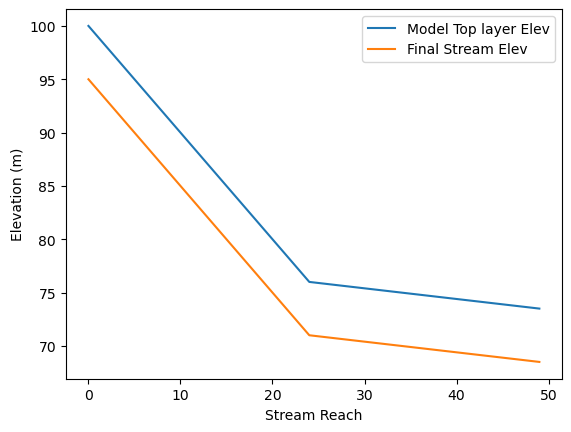

In [6]:
#SFR package inputs

reach = np.recarray((nrow,), dtype=[('k', '<f8'), ('i', '<f8'), ('j', '<f8'), ('iseg', '<f8'), ('ireach', '<f8'), ('rchlen', '<f8'),('strtop', '<f4'),('strhc1', '<f4'),('strthick', '<f4')])


reach[:][:] = 0 # zero it out
reach['k'][:] = 0
reach['i'][:] = int(nrow/2)  #set it to the middle row
reach['j'][:] = [i for i in range(ncol)] #all columns in the middle row
reach['iseg'][:] = 1 #segment number - we only have 1 so all cells - segment number starts with 1!
#reach['iseg'][25:] = 2
reach['ireach'][:50] = [i for i in range(1,51)] #number the 50 reaches - starts with 1!
#reach['ireach'][25:] = [i for i in range(1,26)]
reach['rchlen'][:] = dx * 1.2 #Moderate sinuosity for steeper section from Rosgen 
#reach['rchlen'][25:] = dx * 1.5 #Higher sinuosity for lower slope section from Rosgen 
reach['strhc1'] = 1
reach['strthick'] = 1

str_elevs = np.linspace(ztop[25][0],ztop[25][-1],50) - 5 #ztop[25] #[i for i in ztop[25]] #This was necessary in Transient but not in SS - otherwise it sets the stream elevation to 0 - not sure whyyy

reach['strtop'][:] = ztop[25] - 5 #+ (ztop[25] - str_elevs)*0.5 - 5

#print(reach)
dtype = flopy.modflow.ModflowSfr2.get_default_segment_dtype()
indices = ['nseg','width1','width2','icalc','roughch','flow','outseg','iupseg','hcond1','hcond2','thickm1','thickm2','etsw','pptsw','elevup','elevdn']
#print(dtype)
#print(dtype[indices])
seg_data = np.recarray((1,), dtype[indices])
seg_data[:] = 0
seg_data['width1'] = 5 #2
seg_data['width2'] = 5 #2
seg_data['icalc'] = 1
seg_data['nseg'] = 1
seg_data['roughch'] = 0.045
seg_data['flow'] = 100
seg_data['hcond1'] = 0.0001
seg_data['hcond2'] = 0.0001
seg_data['thickm1'] = 2
seg_data['thickm2'] = 2
#seg_data['elevup'] = 100
#seg_data['elevdn'] = 70
seg_data['etsw'] = 0
seg_data['pptsw'] = 0
seg_data['elevup'] = reach['strtop'][0]   #elevation at start added reach strtop for transeint was 100 and 70 for eleveldn
seg_data['elevdn'] = reach['strtop'][-1]
segment_data = seg_data

nstrm = len(reach)  # number of reaches
nss = 1 #len(seg_data[0])  # number of segments
nsfrpar = 0  # number of parameters (not supported)
nparseg = 0
const = 86400 #turns out were in meters and days so according to flopy this should be 1 for meters x 86400 for days   # constant for manning's equation, units of cfs
dleak = 0.0001 # 0.0001  # closure tolerance for stream stage computation
ipakcb = 53  # flag for writing SFR output to cell-by-cell budget (on unit 53)
istcb2 = 81  # flag for writing SFR output to text file
dataset_5 = {0: [nss, 0, 0]}  # dataset 5 (see online guide)

#str_elevs = np.linspace(ztop[25][24]-2,ztop[25][-1]-1,26)
#streamtest = []
#streamtest = ztop[25] -2
#streamtest[24:] = str_elevs
print(ztop[25] - 5)
plt.plot(ztop[25], label='Model Top layer Elev')
#plt.plot(ztop[25]-1, label='Original Stream Elev')
#plt.plot(streamtest, label='Stream test')
plt.plot(reach['strtop'][:], label = 'Final Stream Elev')
plt.xlabel('Stream Reach')
plt.ylabel('Elevation (m)')
plt.legend()

## create packages and run model

In [7]:
well_head_df= pd.read_pickle('../outputs/heads/WellHead_SS1000test12.pkl')
#print(well_head_df.index.values)


In [9]:
#create model object

#test12 pars correspond to new test 12 runs - finally!
sampling = np.loadtxt("ModflowParams8-1000Test12.txt")

#Testing if this matches
#data = np.loadtxt("../outputs/ModflowSfrWellOutput750Test3.txt")
#sampling = data[:,:-1]

#Using only the members in the ensemble after we cull the herd - 
members = well_head_df.index.values
#print(members)
error_list = []
#print(sampling)
num = len(sampling)
#num = 100
leakage_array = np.zeros((num,1))
depth_array = np.zeros((num,1))

testnum = "12"

for i in range(num):
#for i in members:
    #print(sampling[i])
    modelname = "ScenarioSfrWell1000Test"+str(testnum)+"_"+str(i)#+"NoPumping_"+str(i)
    print("Running ", modelname)
    m = flopy.modflow.Modflow(modelname,model_ws = modws, exe_name = moddir)

    #Discretization - dis
    dis = flopy.modflow.ModflowDis(model=m, nlay=nlay, nrow=nrow, ncol=ncol, 
                               delr=dx, delc=dy, top=ztop, botm=botm, 
                               itmuni = 4, lenuni = 2, 
                               nper=nper, steady=steady)

    # Boundary and initial conditions - bas
    bas = flopy.modflow.ModflowBas(m, ibound=ibound, strt=H_init)

    #Layer properties - lpf
    ## make horizontal K np arrays
    #Kh = np.zeros((nlay,nrow,ncol))     # define an array of zeros the size of the model grid (nlay, nrow, ncol)
    Kh[:,:,:] = sampling[i][0]# assign the original value to the entire array

    ## Make a arrays for the K values
    #Kz = np.zeros((nlay,nrow,ncol))     # define an array of zeros the size of the model grid (nlay, nrow, ncol)
    Kz[:,:,:] = sampling[i][0]#* sampling[i][7]                # assign the original value to the entire array
    
    #restrictive layer
    Kz[1,:,10:49] = sampling[i][0] * sampling[i][1] #* sampling[i][7]       #Replace K in the middle layer with the lower value
    Kh[1,:,10:49] = sampling[i][0] * sampling[i][1]     
    #changed to 10 for start of restrictive layer
    
    Sy = sampling[i][2]
    
    lpf = flopy.modflow.ModflowLpf(m, laytyp=1, hk=Kh, #laywet = [1,1,1],
                               vka=Kz, ss=Ss,
                               sy=Sy,storagecoefficient=True, ipakcb=53)
    #ET - evt
    ET_zone[0,int(ET_rows_forced[0]):int(ET_rows_forced[1]), int(ET_cols_forced[0]):int(ET_cols_forced[1])] = sampling[i][4]
    ET_zone[0,int(rip_rows_forced[0]):int(rip_rows_forced[1]), int(rip_cols_forced[0]):int(rip_cols_forced[1])] = (sampling[i][4] * sampling[i][5])
   
    evt = flopy.modflow.mfevt.ModflowEvt(m, surf=ztop, evtr=ET_zone, exdp=extinction_depth, ipakcb=53) 

    #Recharge - rch
    rech_zone_forced[0,int(rech_rows_forced[0]):int(rech_rows_forced[1]),int(rech_cols_forced[0]):int(rech_cols_forced[1])]= sampling[i][3]
   
    rch = flopy.modflow.mfrch.ModflowRch(model=m, nrchop=3, rech=rech_zone_forced, ipakcb=53)     #create rch object
    
    #seg_data['hcond1'] = sampling[i][6] 
    #seg_data['hcond2'] = sampling[i][6]
    reach['strhc1'] = sampling[i][6]
    
    sfr = flopy.modflow.ModflowSfr2(
        model = m,
        nstrm=nstrm,
        nss=nss,
        const=const,
        dleak=dleak,
        ipakcb=ipakcb,
        isfropt=1,
        #istcb1 = 81,
        istcb2=istcb2,
        reachinput=True,
        reach_data=reach,
        segment_data=seg_data,
        #channel_geometry_data=channel_geometry_data,
        #channel_flow_data=channel_flow_data,
        dataset_5=dataset_5)
    
    sfr.get_slopes() #necessary to calculate slopes when isforpt = 1
    
    #sfr.check()
    #Well - wel
    #wel_spd =  {0: [2,well_row, well_col,0]}
    wel_spd =  {0: [2,well_row, well_col,pumping*sampling[i][7]]}
    wel = flopy.modflow.ModflowWel(model=m, stress_period_data=wel_spd)

    #Output control - OC 
    spd = {(-1, -1): [],
        (0,0):['print head', 'print budget', 'save head', 'save budget']} #create a dictionary for stress period data, where key (0,0) is associated with value ['print...'] 
    oc = flopy.modflow.ModflowOc(model=m, stress_period_data=spd, compact=True)

    #Numerical solver - pcg
    pcg = flopy.modflow.ModflowPcg(model=m, 
                               mxiter=100, iter1=200, 
                               relax = 0.97
                               # damp = 0.7
                              )
   # chk = sfr.check()

    #write the inputs
    #sfr.plot(key='iseg')
    m.write_input()   
    
    #Run the model 
    success, mfoutput = m.run_model(pause=False, report=False, silent=True)
    if not success:
        #raise Exception('MODFLOW did not terminate normally.')      
        print('MODFLOW did not terminate normally. Parameters saved to file')
        #save parameters        
        error_list.append(np.hstack((np.array(i),sampling[i])))
        leakage_array[i] = -1
        depth_array[i] = -1
    else:  
        sfrout = SfrFile(modws+'/'+ modelname+'.sfr.out')
        df = sfrout.get_dataframe()
        leakage_array[i] = df.Qout[25]
        depth_array[i] = df.depth[25]
        print('Success')
        
combined = np.hstack((sampling[:],leakage_array))

if error_list:
    np.savetxt("ErrorSS_SfrWell1000Test"+str(testnum)+".txt", error_list)
    print(len(error_list))
    eidx = np.array(error_list)[:,0].astype(int)
    print(eidx)
    #pumping
    error_free = np.delete(combined, eidx, axis=0) 
    #no Pumping
    #error_free = [i for i in members if i not in eidx]
else:
    print('No Errors')
    error_free = combined

np.savetxt("ModflowSfrWellOutput1000Test"+str(testnum)+".txt", error_free)

Running  ScenarioSfrWell1000Test12_0
Success
Running  ScenarioSfrWell1000Test12_1
Success
Running  ScenarioSfrWell1000Test12_2
Success
Running  ScenarioSfrWell1000Test12_3
Success
Running  ScenarioSfrWell1000Test12_4
Success
Running  ScenarioSfrWell1000Test12_5
Success
Running  ScenarioSfrWell1000Test12_6
Success
Running  ScenarioSfrWell1000Test12_7
Success
Running  ScenarioSfrWell1000Test12_8
Success
Running  ScenarioSfrWell1000Test12_9
Success
Running  ScenarioSfrWell1000Test12_10
Success
Running  ScenarioSfrWell1000Test12_11
Success
Running  ScenarioSfrWell1000Test12_12
Success
Running  ScenarioSfrWell1000Test12_13
Success
Running  ScenarioSfrWell1000Test12_14
Success
Running  ScenarioSfrWell1000Test12_15
MODFLOW did not terminate normally. Parameters saved to file
Running  ScenarioSfrWell1000Test12_16
Success
Running  ScenarioSfrWell1000Test12_17
Success
Running  ScenarioSfrWell1000Test12_18
Success
Running  ScenarioSfrWell1000Test12_19
Success
Running  ScenarioSfrWell1000Test12_20

Success
Running  ScenarioSfrWell1000Test12_174
Success
Running  ScenarioSfrWell1000Test12_175
Success
Running  ScenarioSfrWell1000Test12_176
Success
Running  ScenarioSfrWell1000Test12_177
Success
Running  ScenarioSfrWell1000Test12_178
Success
Running  ScenarioSfrWell1000Test12_179
Success
Running  ScenarioSfrWell1000Test12_180
Success
Running  ScenarioSfrWell1000Test12_181
Success
Running  ScenarioSfrWell1000Test12_182
Success
Running  ScenarioSfrWell1000Test12_183
Success
Running  ScenarioSfrWell1000Test12_184
Success
Running  ScenarioSfrWell1000Test12_185
Success
Running  ScenarioSfrWell1000Test12_186
Success
Running  ScenarioSfrWell1000Test12_187
Success
Running  ScenarioSfrWell1000Test12_188
Success
Running  ScenarioSfrWell1000Test12_189
Success
Running  ScenarioSfrWell1000Test12_190
Success
Running  ScenarioSfrWell1000Test12_191
Success
Running  ScenarioSfrWell1000Test12_192
Success
Running  ScenarioSfrWell1000Test12_193
Success
Running  ScenarioSfrWell1000Test12_194
Success
Runni

Success
Running  ScenarioSfrWell1000Test12_341
Success
Running  ScenarioSfrWell1000Test12_342
Success
Running  ScenarioSfrWell1000Test12_343
Success
Running  ScenarioSfrWell1000Test12_344
Success
Running  ScenarioSfrWell1000Test12_345
Success
Running  ScenarioSfrWell1000Test12_346
Success
Running  ScenarioSfrWell1000Test12_347
Success
Running  ScenarioSfrWell1000Test12_348
Success
Running  ScenarioSfrWell1000Test12_349
Success
Running  ScenarioSfrWell1000Test12_350
Success
Running  ScenarioSfrWell1000Test12_351
Success
Running  ScenarioSfrWell1000Test12_352
Success
Running  ScenarioSfrWell1000Test12_353
Success
Running  ScenarioSfrWell1000Test12_354
Success
Running  ScenarioSfrWell1000Test12_355
Success
Running  ScenarioSfrWell1000Test12_356
Success
Running  ScenarioSfrWell1000Test12_357
Success
Running  ScenarioSfrWell1000Test12_358
Success
Running  ScenarioSfrWell1000Test12_359
Success
Running  ScenarioSfrWell1000Test12_360
Success
Running  ScenarioSfrWell1000Test12_361
Success
Runni

Success
Running  ScenarioSfrWell1000Test12_511
Success
Running  ScenarioSfrWell1000Test12_512
Success
Running  ScenarioSfrWell1000Test12_513
Success
Running  ScenarioSfrWell1000Test12_514
Success
Running  ScenarioSfrWell1000Test12_515
Success
Running  ScenarioSfrWell1000Test12_516
Success
Running  ScenarioSfrWell1000Test12_517
Success
Running  ScenarioSfrWell1000Test12_518
Success
Running  ScenarioSfrWell1000Test12_519
Success
Running  ScenarioSfrWell1000Test12_520
Success
Running  ScenarioSfrWell1000Test12_521
Success
Running  ScenarioSfrWell1000Test12_522
Success
Running  ScenarioSfrWell1000Test12_523
Success
Running  ScenarioSfrWell1000Test12_524
Success
Running  ScenarioSfrWell1000Test12_525
Success
Running  ScenarioSfrWell1000Test12_526
Success
Running  ScenarioSfrWell1000Test12_527
Success
Running  ScenarioSfrWell1000Test12_528
Success
Running  ScenarioSfrWell1000Test12_529
Success
Running  ScenarioSfrWell1000Test12_530
Success
Running  ScenarioSfrWell1000Test12_531
Success
Runni

Success
Running  ScenarioSfrWell1000Test12_682
Success
Running  ScenarioSfrWell1000Test12_683
Success
Running  ScenarioSfrWell1000Test12_684
Success
Running  ScenarioSfrWell1000Test12_685
Success
Running  ScenarioSfrWell1000Test12_686
Success
Running  ScenarioSfrWell1000Test12_687
Success
Running  ScenarioSfrWell1000Test12_688
Success
Running  ScenarioSfrWell1000Test12_689
Success
Running  ScenarioSfrWell1000Test12_690
Success
Running  ScenarioSfrWell1000Test12_691
Success
Running  ScenarioSfrWell1000Test12_692
Success
Running  ScenarioSfrWell1000Test12_693
Success
Running  ScenarioSfrWell1000Test12_694
Success
Running  ScenarioSfrWell1000Test12_695
Success
Running  ScenarioSfrWell1000Test12_696
Success
Running  ScenarioSfrWell1000Test12_697
Success
Running  ScenarioSfrWell1000Test12_698
Success
Running  ScenarioSfrWell1000Test12_699
Success
Running  ScenarioSfrWell1000Test12_700
Success
Running  ScenarioSfrWell1000Test12_701
Success
Running  ScenarioSfrWell1000Test12_702
Success
Runni

Success
Running  ScenarioSfrWell1000Test12_856
Success
Running  ScenarioSfrWell1000Test12_857
Success
Running  ScenarioSfrWell1000Test12_858
Success
Running  ScenarioSfrWell1000Test12_859
Success
Running  ScenarioSfrWell1000Test12_860
Success
Running  ScenarioSfrWell1000Test12_861
Success
Running  ScenarioSfrWell1000Test12_862
Success
Running  ScenarioSfrWell1000Test12_863
Success
Running  ScenarioSfrWell1000Test12_864
Success
Running  ScenarioSfrWell1000Test12_865
Success
Running  ScenarioSfrWell1000Test12_866
Success
Running  ScenarioSfrWell1000Test12_867
Success
Running  ScenarioSfrWell1000Test12_868
Success
Running  ScenarioSfrWell1000Test12_869
Success
Running  ScenarioSfrWell1000Test12_870
Success
Running  ScenarioSfrWell1000Test12_871
Success
Running  ScenarioSfrWell1000Test12_872
Success
Running  ScenarioSfrWell1000Test12_873
Success
Running  ScenarioSfrWell1000Test12_874
Success
Running  ScenarioSfrWell1000Test12_875
Success
Running  ScenarioSfrWell1000Test12_876
Success
Runni

## Saving the output Q

[2.43334820e+00 2.34366527e-01 2.53663888e-01 1.75224971e-03
 2.03412189e-05 4.03892302e+00 9.04723893e+00 1.57584954e+00]
[6220.4]


,STORAGE_IN,CONSTANT_HEAD_IN,WELLS_IN,ET_IN,RECHARGE_IN,STREAM_LEAKAGE_IN,TOTAL_IN,STORAGE_OUT,CONSTANT_HEAD_OUT,WELLS_OUT,ET_OUT,RECHARGE_OUT,STREAM_LEAKAGE_OUT,TOTAL_OUT,IN-OUT,PERCENT_DISCREPANCY
1970-01-02,0.0,0.0,0.0,0.0,11424.670898,123.281197,11547.952148,0.0,997.271118,3151.698975,116.940498,0.0,7281.880859,11547.791016,0.1611,0.0


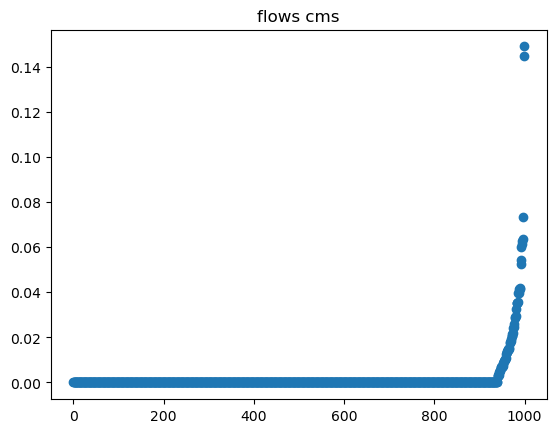

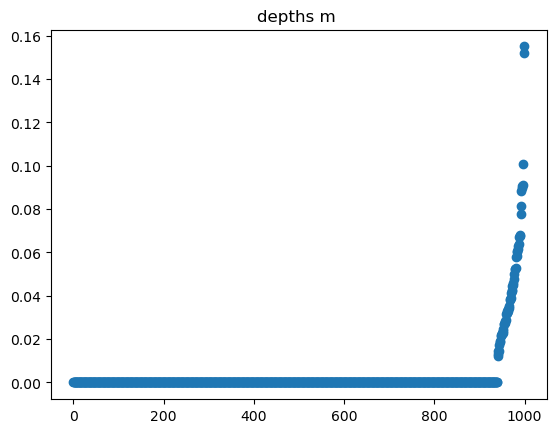

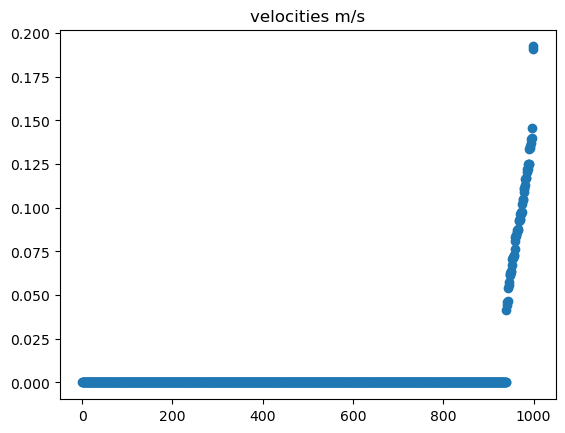

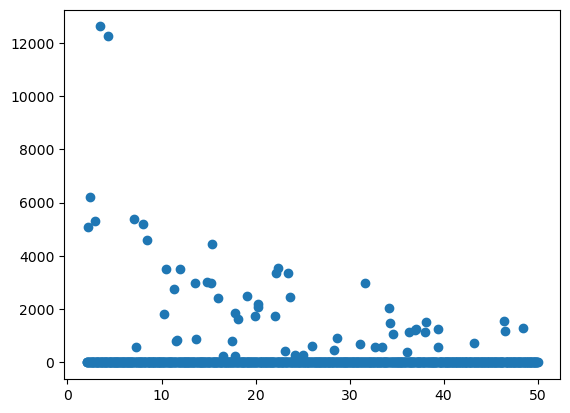

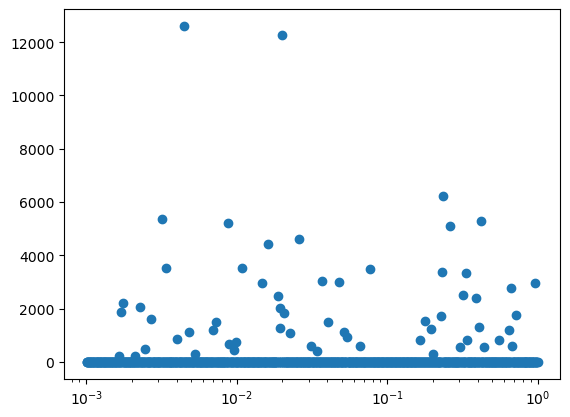

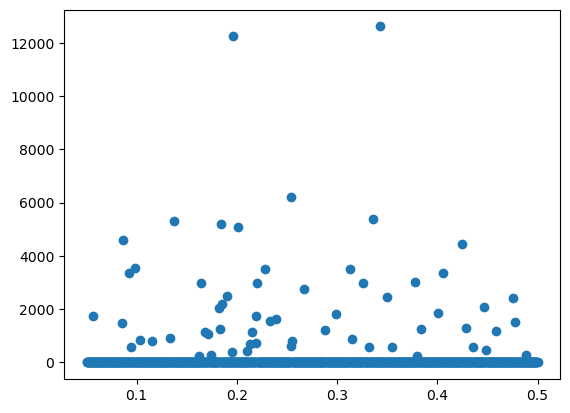

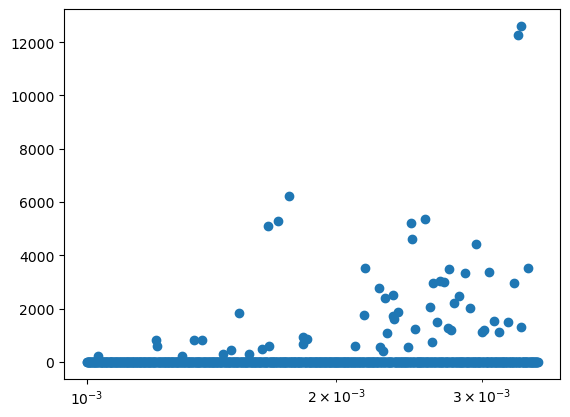

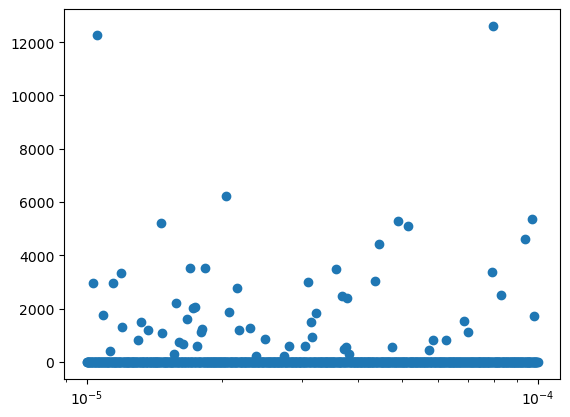

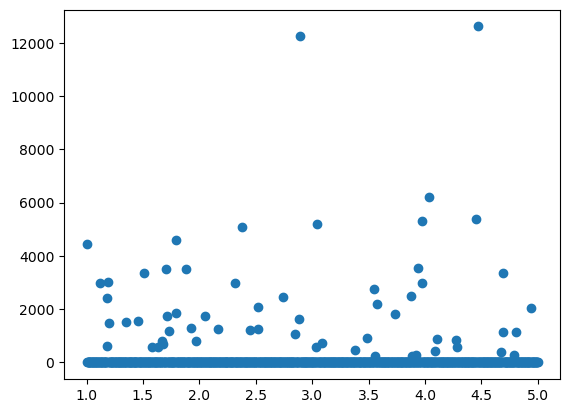

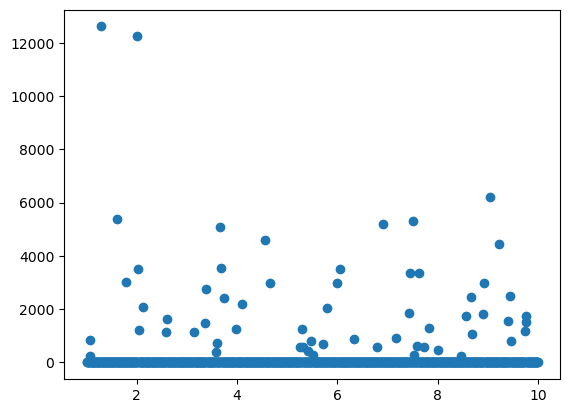

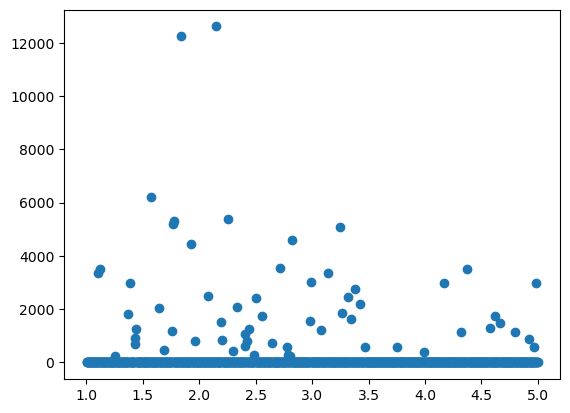

In [129]:
#
from flopy.utils.mflistfile import MfListBudget
#print(sfr.check())
print(sampling[1])
print(leakage_array[1])
mf_list = MfListBudget(modws+"/ScenarioSfrWell1000Test12_1.list")
#incremental, cumulative = mf_list.get_budget()
df_in, df_out = mf_list.get_dataframes()

display(df_out)
#print(sfr.get_slopes())
leakage = np.delete(leakage_array,np.where(leakage_array == -1)) / 84600
depth_array = np.delete(depth_array,np.where(depth_array == -1))
vel_array = np.nan_to_num(leakage / (depth_array * 5)) #V = Q/A with rectangular 5m channel

plt.title('flows cms')
plt.scatter(range(len(leakage)),sorted(leakage))
plt.show()

plt.title('depths m ')
plt.scatter(range(len(depth_array)),sorted(depth_array))
plt.show()

plt.title('velocities m/s')
plt.scatter(range(len(vel_array)),sorted(vel_array))
plt.show()

for i in range(npars):
    plt.scatter(sampling[:len(leakage_array), i], leakage_array)
    if i in logpars:
        plt.xscale('log')
    plt.show()


In [6]:
sampling = np.loadtxt("ModflowParams8-1000Test4.txt")
print(sampling[-1])

[7.08797415e+00 4.68023260e-02 6.67353018e-02 2.77475939e-03
 2.98086662e-05 3.13369438e+00 2.54820600e+00 1.73187392e+00]


In [5]:

#combined = np.hstack((sampling[:],leakage_array))
combined = sampling[:]
#print(len(combined))
error_list = np.loadtxt("ErrorSS_SfrWell1000Test10.txt")
if error_list.shape[0] > 0:
    eidx = np.array(error_list)[:,0].astype(int)
    print(eidx)
    error_free = np.delete(combined, eidx, axis=0)
   # error_free = [i for i in members if i not in eidx]
else:
    error_free = combined
#print(error_list[:,0])
#eidx = np.array(error_list)[:,0].astype(int)

#error_free = np.delete(combined, eidx, axis=0)
#print(error_free)

#np.savetxt("ModflowSfrWellOutput750Test5.txt", error_free)
np.savetxt("ModflowSfrWellOutput1000Test10.txt", error_free)

test = np.loadtxt("ModflowSfrWellOutput1000Test9.txt")
#if test:
print('yay', test.shape)
#print(test)

[ 28  29  62  74  95 109 120 127 137 141 144 172 183 204 221 257 274 279
 280 296 334 358 359 367 383 387 439 455 463 465 474 488 491 496 504 512
 521 550 570 576 585 592 594 640 643 661 679 736 750 773 794 826 837 856
 884 899 919 954 980 994 999]
yay (959, 9)


In [19]:
#Only for non pumping scenarios
well_head_df= pd.read_pickle('../outputs/heads/WellHead_SS1000test10.pkl')
members = well_head_df.index.values
print(members.shape)
#error_list = np.loadtxt("ErrorSS_SfrWell1000Test10NoPumping.txt")
# eidx = np.array(error_list)[:,0].astype(int)
# print(eidx)
# error_free = [i for i in members if i not in eidx]
error_free = members
np.savetxt("ModflowSfrWellOutput1000Test10NoPumping.txt", error_free)

test = np.loadtxt("ModflowSfrWellOutput1000Test10NoPumping.txt")
print('yay', test.shape)


(825,)
yay (825,)


C:\Users\davem\anaconda3\lib\site-packages\flopy\plot\crosssection.py:1693: MatplotlibDeprecationWarning: Passing the match_original parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  patches = PatchCollection(rectcol, match_original, **kwargs)
C:\Users\davem\anaconda3\lib\site-packages\flopy\plot\crosssection.py:1693: MatplotlibDeprecationWarning: Passing the match_original parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  patches = PatchCollection(rectcol, match_original, **kwargs)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


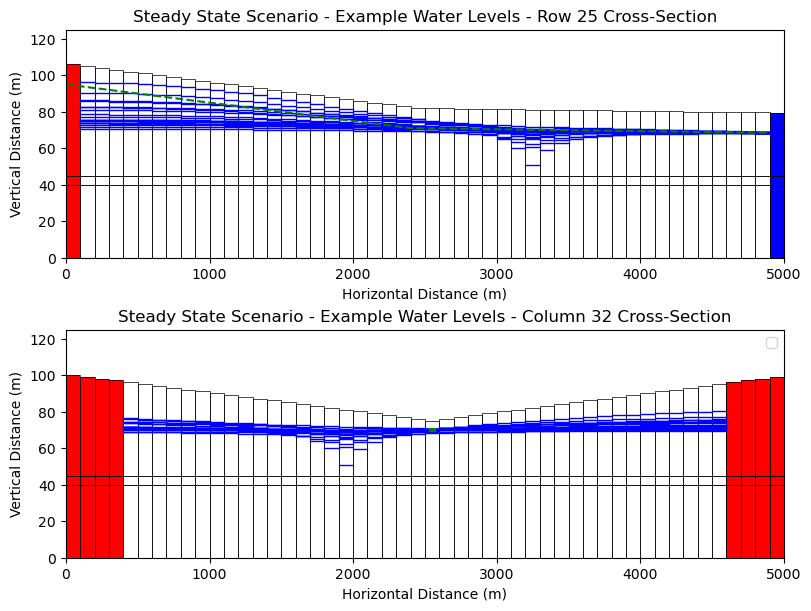

In [21]:
well_head_df= pd.read_pickle('../outputs/heads/WellHead_SS1000test12.pkl')
#print(well_head_df.index.values)
#print(well_head_df.index.shape)
members = well_head_df.index.values

#temprange = np.arange(750)
#eidx = np.array(error_list)[:,0].astype(int)
#error_free = np.delete(temprange, eidx, axis=0)
mn = "D:/mfoutput/ScenarioSfrWell1000Test12_0.nam"
# error_list = np.loadtxt("ErrorSS_SfrWell750Test5.txt")
#error_list = np.loadtxt("ErrorSS_SfrWell1000Test12.txt")#accidently saved the 12 pumping scenario as the nopumping
# eidx = np.array(error_list)[:,0].astype(int)
# temprange = np.arange(1000)
# error_free = np.delete(temprange, eidx, axis=0)

m = flopy.modflow.Modflow.load(mn)

fig = plt.figure(figsize=(8, 6),constrained_layout=True)

ax = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)
#ax3 = fig.add_subplot(3, 1, 3)
#fig.tight_layout()
xsect = flopy.plot.PlotCrossSection(model=m, line={'column':32}, ax=ax2) #note use the key 'column' if you want to plot a column instaed
xsectzoom = flopy.plot.PlotCrossSection(model=m, line={'column':32}, extent=(2200,3000,65,80), ax=ax3) #zoomed in to certain x - y
xsectlong = flopy.plot.PlotCrossSection(model=m, line={'row':19}, ax=ax) #note use the key 'column' if you want to plot a column instaed


patcheslong = xsectlong.plot_ibound(color_noflow='red', color_ch='blue',ax=ax)
patches = xsect.plot_ibound(color_noflow='red', color_ch='blue',ax=ax2)
ax.set_xlabel('Horizontal Distance (m)')
ax.set_ylabel('Vertical Distance (m)')
ax2.set_xlabel('Horizontal Distance (m)')
ax2.set_ylabel('Vertical Distance (m)')
linecollection = xsect.plot_grid(color='black', lw=0.5)
linecollectionlong = xsectlong.plot_grid(color='black', lw=0.5)

linecollectionzoom = xsectzoom.plot_grid(color='black', lw=0.5,alpha=0.5)
t = ax.set_title('Steady State Scenario - Example Water Levels - Row 25 Cross-Section')
t = ax2.set_title('Steady State Scenario - Example Water Levels - Column 32 Cross-Section')
colors = ['c','k']

#Overlay the head in a layer of the model- in this case I'm doing the top layer i.e. head3[0,:,:]
import random
#rand_list = [int(error_free[i][-1]) for i in range(0,75)]
#rand_list = random.choice(error_free,size=25)
#for i in rand_list: #rand_list[:100]:
#for k,i in enumerate(error_free[0:100]):
for i in members[:20]:
    modelname = "ScenarioSfrWell1000Test12_"+str(i)
    #modelname = "ScenarioSfrWell750Test5_"+str(i)

    fname = modws+'/'+modelname+'.hds'
    hdobj = flopy.utils.HeadFile(fname)
    head = hdobj.get_data()
    wtup = xsect.plot_surface(head[0], lw=1)#, color=colors[k])
    wtuplong = xsectlong.plot_surface(head[0], lw=1)#, color=colors[k])

    wtupzoom = xsectzoom.plot_surface(head[0])#, lw=1, color=colors[k])
    #print(i," pumping head: ",head[0][25][32])
   # wtlow = xsect.plot_surface(head[2], lw=0.5, alpha=0.5, color='purple')
    
    
    fname = modws+'/'+modelname+'.sfr.out'
    sfrout = SfrFile(fname).get_dataframe()   
    
   # ax3.plot(np.arange(2545,2570,5),np.repeat(sfrout.loc[32,'stage'],5),color='purple',linestyle='solid', lw=3)

    #no Pumping
#     modelname = "ScenarioSfrWell1000Test12NoPumping_"+str(i)
#     #modelname = "ScenarioSfrWell750Test5_"+str(i)

#     fname = modws+'/'+modelname+'.hds'
#     hdobj = flopy.utils.HeadFile(fname)
#     nopumphead = hdobj.get_data()
#     nopumpwtup = xsect.plot_surface(nopumphead[0], lw=1, color='k', linestyle='dotted')
#     nopumpwtupzoom = xsectzoom.plot_surface(nopumphead[0], lw=1,color='k', linestyle='dotted')

#     print(i," No Pumping head: ",nopumphead[0][25][32])
ax.plot(np.arange(0,5000,100),reach['strtop'][:],color='green',linestyle='dashed', lw=1.5)
#plt.plot(np.arange(0,5000,100),ztop[25][:],color='black',linestyle='solid', lw=1.5)
#ax.plot(np.arange(2510,2610,10),np.repeat(reach['strtop'][32],10),color='green',linestyle='solid', lw=3)
ax2.plot(np.arange(2545,2570,5),np.repeat(reach['strtop'][32],5),color='green',linestyle='solid', lw=3)
#ax3.plot(np.arange(2545,2570,5),np.repeat(reach['strtop'][32],5),color='green',linestyle='solid', lw=3)

plt.legend()


## Read SFR outputs

,layer,row,column,segment,reach,Qin,Qaquifer,Qout,Qovr,Qprecip,Qet,stage,depth,width,Cond,gradient,kstpkper,k,i,j
0,1,26,1,1,1,100.0,0.0000,100.0,0.0,0.0,0.0,95.0043,0.004309,5.0,0.0,0.000000,"(0, 0)",0,25,0
1,1,26,2,1,2,100.0,100.0000,0.0,0.0,0.0,0.0,94.0010,0.000970,5.0,5862.0,1.001000,"(0, 0)",0,25,1
2,1,26,3,1,3,0.0,0.0000,0.0,0.0,0.0,0.0,93.0000,0.000000,5.0,5862.0,1.000000,"(0, 0)",0,25,2
3,1,26,4,1,4,0.0,0.0000,0.0,0.0,0.0,0.0,92.0000,0.000000,5.0,5862.0,1.000000,"(0, 0)",0,25,3
4,1,26,5,1,5,0.0,0.0000,0.0,0.0,0.0,0.0,91.0000,0.000000,5.0,5862.0,1.000000,"(0, 0)",0,25,4
5,1,26,6,1,6,0.0,0.0000,0.0,0.0,0.0,0.0,90.0000,0.000000,5.0,5862.0,1.000000,"(0, 0)",0,25,5
6,1,26,7,1,7,0.0,0.0000,0.0,0.0,0.0,0.0,89.0000,0.000000,5.0,5862.0,1.000000,"(0, 0)",0,25,6
7,1,26,8,1,8,0.0,0.0000,0.0,0.0,0.0,0.0,88.0000,0.000000,5.0,5862.0,1.000000,"(0, 0)",0,25,7
8,1,26,9,1,9,0.0,0.0000,0.0,0.0,0.0,0.0,87.0000,0.000000,5.0,5862.0,1.000000,"(0, 0)",0,25,8
9,1,26,10,1,10,0.0,0.0000,0.0,0.0,0.0,0.0,86.0000,0.000000,5.0,5862.0,1.000000,"(0, 0)",0,25,9


[95.  94.  93.  92.  91.  90.  89.  88.  87.  86.  85.  84.  83.  82.
 81.  80.  79.  78.  77.  76.  75.  74.  73.  72.  71.  70.9 70.8 70.7
 70.6 70.5 70.4 70.3 70.2 70.1 70.  69.9 69.8 69.7 69.6 69.5 69.4 69.3
 69.2 69.1 69.  68.9 68.8 68.7 68.6 68.5]
[0.0, 6220.4, 1076.0, 1180.6, 2973.9, 0.0, 741.29, 4437.6, 0.0, 0.0, 0.0, 1539.9, 1733.6, 5371.3, 0.0, 231.84, 0.0, 926.34, 0.0, 0.0, 0.0, 1129.5, 2999.3, 5194.2, 821.78, 0.0, 1623.9, 0.0, 0.0, 597.9, 2066.6, 5098.3, 0.0, 0.0, 3490.8, 0.0, 4596.0, 838.64, 5292.5, 0.0, 1203.0, 2210.6, 2408.6, 231.73, 0.0, 678.64, 0.0, 2966.7, 12612.0, 12262.0, 567.8, 0.0, 0.0, 0.0, 0.0, 2757.2, 0.0, 0.0, 283.78, 570.17, 470.27, 870.63, 1251.2, 0.0, 0.0, 0.0, 284.37, 3372.3, 0.0, 0.0, 613.7, 0.0, 0.0, 588.12, 0.0, 402.29, 1505.3, 1132.2, 2029.1, 3035.8, 439.47, 1817.8, 2463.0, 0.0, 0.0, 0.0, 3505.2, 3345.5, 2498.2, 1272.4, 1859.0, 0.0, 3538.1, 0.0, 0.0, 1312.0, 805.28, 0.0, 1496.6, 1747.3]


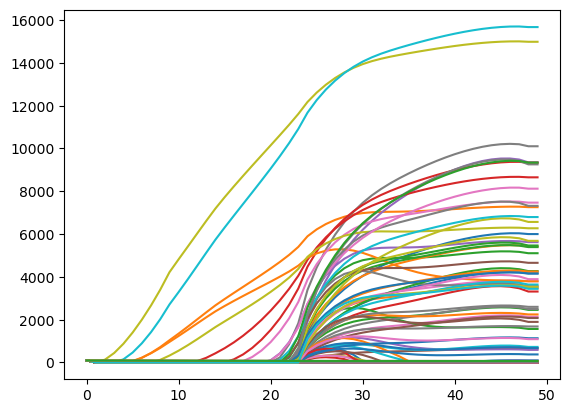

In [141]:
qout = []
for i in range(100):#error_free[:100]:
    modelname = "ScenarioSfrWell1000Test12_"+str(i)
    #modelname = "ScenarioSfrWell750Test5_"+str(i)
    fname = modws+'/'+modelname+'.sfr.out'
    sfrout = SfrFile(fname)    
    testdf = sfrout.get_dataframe()
    testdf.Qout.plot()
    qout.append(testdf.loc[25,'Qout'])
   # display(testdf.loc[32])
#sfrout = SfrFile(modws+'/ScenarioSfr750.sfr.out')
#df = sfrout.get_dataframe()
#rint(df)
display(testdf)
print(reach['strtop'])
plt.plot(testdf.stage)
plt.plot(reach['strtop'])
plt.plot(testdf.depth +reach['strtop'])
print(qout)

In [145]:
gz = [i for i in qout if i > 0]
print(gz,len(gz))

[6220.4, 1076.0, 1180.6, 2973.9, 741.29, 4437.6, 1539.9, 1733.6, 5371.3, 231.84, 926.34, 1129.5, 2999.3, 5194.2, 821.78, 1623.9, 597.9, 2066.6, 5098.3, 3490.8, 4596.0, 838.64, 5292.5, 1203.0, 2210.6, 2408.6, 231.73, 678.64, 2966.7, 12612.0, 12262.0, 567.8, 2757.2, 283.78, 570.17, 470.27, 870.63, 1251.2, 284.37, 3372.3, 613.7, 588.12, 402.29, 1505.3, 1132.2, 2029.1, 3035.8, 439.47, 1817.8, 2463.0, 3505.2, 3345.5, 2498.2, 1272.4, 1859.0, 3538.1, 1312.0, 805.28, 1496.6, 1747.3] 60


C:\Users\davem\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:609: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles = leg.legendHandles


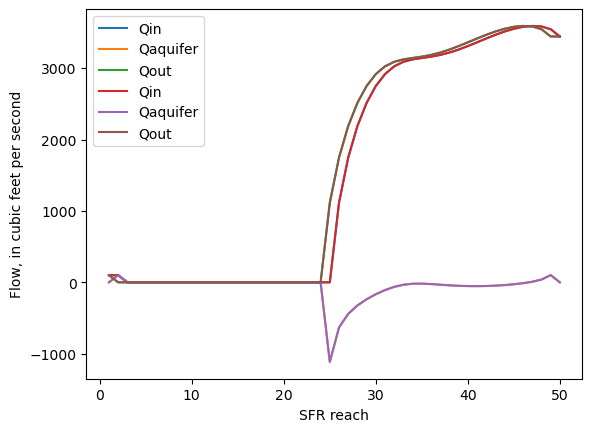

In [139]:
inds = df.segment == 1
#print(df.reach[inds].astype(str))
ax = df.loc[inds, ["reach", "Qin", "Qaquifer", "Qout"]].plot(x="reach")
testdf.loc[inds, ["reach", "Qin", "Qaquifer", "Qout"]].plot(x="reach", ax = ax)
ax.set_ylabel("Flow, in cubic feet per second")
ax.set_xlabel("SFR reach");

## read in outputs

None
passed.

Checking for continuity in segment and reach numbering...
passed.

Checking for increasing segment numbers in downstream direction...
passed.

Checking for circular routing...
passed.

Checking reach connections for proximity...
0 segments with non-adjacent reaches found.
At segments:


0 segments with non-adjacent reaches found.
At segments:



Checking for model cells with multiple non-zero SFR conductances...
passed.

Checking for streambed tops of less than -10...
passed.

Checking for streambed tops of greater than 15000...
passed.

Checking segment_data for downstream rises in streambed elevation...
Segment elevup and elevdn not specified for nstrm=50 and isfropt=1
passed.

Checking reach_data for downstream rises in streambed elevation...
passed.

Checking reach_data for inconsistencies between streambed elevations and the model grid...
passed.

Checking segment_data for inconsistencies between segment end elevations and the model grid...
Segment elevup and elevdn 

<Axes: xlabel='Distance along path, in miles', ylabel='Elevation, in meters'>

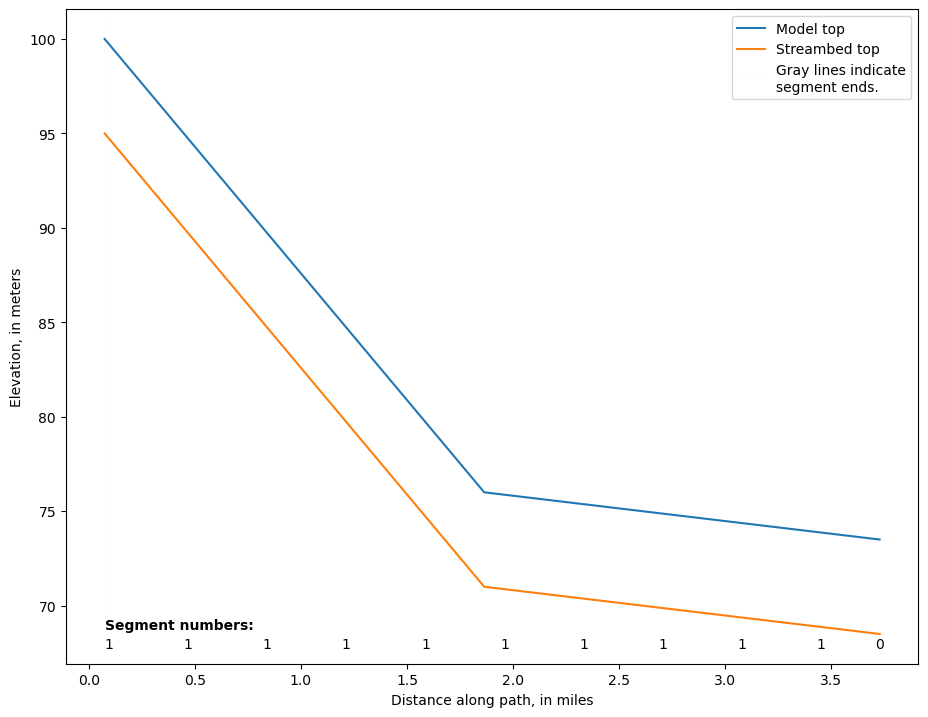

In [91]:
print(sfr.get_slopes())
sfr.check()
sfr.plot_path(start_seg=1)